### Library imports

In [1]:
from IPython.display import Image, display
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import base64
import math
import os

### Function definitions

In [2]:
## Function to encode image

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [3]:
## Function to display frames of accident

def display_images(image_paths, frame_x):

    if len(image_paths) > 50:
        raise ValueError("Please provide no more than 50 image paths.")

    num_images = len(image_paths)
    num_columns = 5
    num_rows = math.ceil(num_images / num_columns)

    # Create a figure with dynamic rows and fixed 5 columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    for i in range(num_rows * num_columns):

        if i < num_images:

            img = mpimg.imread(image_paths[i])  # Load image
            axes[i].imshow(img)                # Display image on the respective subplot
            axes[i].axis('off')                # Hide axes

            frame_num = int(image_paths[i].rsplit('_', 1)[-1].split('.')[0])
            if frame_num == int(frame_x):
                axes[i].set_title(f"Frame {frame_num} (ACCIDENT)")  # Specify accident frame
            else:
                axes[i].set_title(f"Frame {frame_num}")  # Add title to each subplot

        else:
            axes[i].axis('off')  # Turn off empty axes for fewer images

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [4]:
## Function to find the frame in which the accident first occurred

def find_first_accident_frame(video_name, csv_path="/home/abdulla.almarzooqi/Desktop/Thesis/datasets/car-crash-dataset-ccd/Crash_Table.csv"):
    # Load the CSV file, ensuring vidname is treated as a string
    df = pd.read_csv(csv_path, dtype={'vidname': str})

    # Strip any leading or trailing spaces from column names
    df.columns = df.columns.str.strip()

    # Filter the row for the given video name
    video_row = df[df['vidname'] == video_name.strip()]

    if video_row.empty:
        return f"Video name {video_name} not found in the dataset."

    # Inspect each frame column (frame_1 to frame_50)
    for frame_num in range(1, 51):
        frame_label = video_row[f'frame_{frame_num}'].values[0]
        if frame_label == 1:
            return frame_num

    return f"No accident detected in video {video_name}."

In [5]:
## Function to zero-pad a number to 6 digits

def zero_pad_to_six_digits(number):
    return f"{int(number):06}"

In [6]:
## Function to display all 50 frames

def display_all_images(video_name):
    video_name = zero_pad_to_six_digits(video_name)
    frame_x = find_first_accident_frame(video_name)
    a = [f"{x:02}" for x in range(1,51)]
    imgs = sample_images(video_name, a)
    images = [os.path.join(folder_path, image) for image in imgs]
    display_images(images, frame_x)

In [7]:
## Function to create the required image names

def sample_images(vidname, frames):
    img_list = [f"C_{vidname}_{frame}.jpg" for frame in frames]
    return img_list

In [8]:
## Function to sample frames

def sample_frames(video_name):

    # find the accident frame
    frame_x = find_first_accident_frame(video_name)

    if not isinstance(frame_x, int):
        return frame_x  # Return the error message if no accident frame is found

    print(f"Accident frame: Frame {frame_x}\n")

    # Sample frames before frame_x every 5 frames starting from frame 1
    before_frames = list(range(1, frame_x, 5))

    # Sample frames after frame_x every other frame
    after_frames = list(range(frame_x + 2, 51, 2))

    # Combine and zero-pad frames
    sampled_frames = before_frames + [frame_x] + after_frames
    sampled_frames = [f"{frame:02}" for frame in sampled_frames if 1 <= frame <= 50]

    print(f"{len(sampled_frames)} frames sampled: {sampled_frames}")

    imgs = sample_images(video_name, sampled_frames)

    return imgs, frame_x

In [9]:
## Function to run the system and get the accident report

def get_report_sampling(video_name, display_img):
    video_name = zero_pad_to_six_digits(video_name)
    sampled_imgs, accident_frame = sample_frames(video_name)

    imgs = [os.path.join(folder_path, image) for image in sampled_imgs]

    if display_img:
        display_images(imgs, accident_frame)

    # Create the list of image data in base64 format
    image_data = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image(os.path.join(folder_path, image))}",
                "detail": "low",
            },
        }
        for image in sampled_imgs
    ]

    sampling_prompt = "Given the following frames extracted from a video footage of a road accident, describe the accident in detail (including which vehicle was in fault and which was not, and whether the ego vehicle was involved in the accident). Note that the accident might start in the later frames and not the early ones depending on the situation, so keep that in mind and be careful in your analysis."

    # Use OpenAI API to send the request
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that provides a detailed accident report given a set of frames extracted from a video footage of an accident.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": sampling_prompt},
                    *image_data,
                ],
            },
        ],
    )

    # Print the response
    print("\n[[ Generated Report ]]\n")
    print(response.choices[0].message.content)

In [10]:
## Function to get the description of the first set of frames

def first_prompt(video_name):

    # frames = ["01", "02", "03", "04", "05"] # NORMAL
    frames = ["01", "03", "05", "07", "09"] # SKIP

    sampled_imgs = sample_images(video_name, frames)

    # Create the list of image data in base64 format
    image_data = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image(os.path.join(folder_path, image))}",
                "detail": "low",
            },
        }
        for image in sampled_imgs
    ]

    # Use OpenAI API to send the request
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that describes the driving scene of given images in detail.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Given the following frames extracted from a video footage of a driving scene, describe the scene in detail."},
                    *image_data,
                ],
            },
        ],
    )

    # Return the response
    return response.choices[0].message.content

In [11]:
## Function to get the intermediate descriptions

def intermediate_prompts(video_name, frames, prev_description):

    sampled_imgs = sample_images(video_name, frames)

    # Create the list of image data in base64 format
    image_data = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image(os.path.join(folder_path, image))}",
                "detail": "low",
            },
        }
        for image in sampled_imgs
    ]

    intermediate_prompt = f"""
    The following images are some frames extracted from a video footage of a driving scene that contains an accident. In the given frames, the accident might not have started yet, or it may start during those frames, or it may occur during the upcoming frames, so keep that in mind.

    On top of those given frames, I will give you also a textual description of earlier frames from this video. This description will be enclosed within triple backticks above and below. The following is the description to note:

    '''
    {prev_description}
    '''

    Your task is the following:

    Referring to the current frames and the textual description of previous frames, describe what happened in this video so far (i.e., what happened from the previous first frame until now). In case of an accident, mention its details including with which vehicle was at fault.
    """

    # Use OpenAI API to send the request
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that describes the driving scene of given images in detail.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": intermediate_prompt},
                    *image_data,
                ],
            },
        ],
    )

    # Return the response
    return response.choices[0].message.content

In [12]:
## Function to get the description of the last set of frames

def last_prompt(video_name, prev_description):

    # frames = ["46", "47", "48", "49", "50"] # NORMAL
    frames = ["41", "43", "45", "47", "49"] # SKIP

    sampled_imgs = sample_images(video_name, frames)

    # Create the list of image data in base64 format
    image_data = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image(os.path.join(folder_path, image))}",
                "detail": "low",
            },
        }
        for image in sampled_imgs
    ]

    last_pr = f"""The following is the last batch of 5 frames extracted from a video footage of a driving scene that contains an accident. As of now, the accident did certainly occur either in the current frames or from before.

    For your information, I will give you also a textual description of earlier frames from this video. This description will be enclosed within triple backticks above and below. The following is the description to note:

    '''
    {prev_description}
    '''

    Your task is the following:

    Referring to the current frames and the textual description of previous frames, describe how the accident happened since the very beginning of the video mentioning the important details (including a fault analysis of which vehicle was at fault).
    """

    # Use OpenAI API to send the request
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that describes the driving scene of given images in detail.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": last_pr},
                    *image_data,
                ],
            },
        ],
    )

    # Return the response
    return response.choices[0].message.content

In [13]:
## Function to get the accident report recursively

def get_report_recursive(video_name, display_img):

    video_name = zero_pad_to_six_digits(video_name)

    if display_img:
        display_all_images(video_name)
        print()

    # Get the first description
    print(f"Processing batch 01 - frames ['01', '03', '05', '07', '09']...")
    first_description = first_prompt(video_name)

    intermediate_frames = [f"{x:02}" for x in range(11, 40, 2)]

    # Initialize the current description
    current_description = first_description
    counter = 2

    # Iterate through the intermediate frames in batches of 5
    for i in range(0, len(intermediate_frames), 5):
        frame_batch = intermediate_frames[i:i+5]

        # Update the description using the current frame batch
        print(f"Processing batch {counter:02} - frames {frame_batch}...")
        current_description = intermediate_prompts(video_name, frame_batch, current_description)
        counter += 1

    # Final iteration
    print(f"Processing batch {counter:02} - frames ['41', '43', '45', '47', '49']...", end="")
    current_description = last_prompt(video_name, current_description)
    print(" Done.")

    print("\n[[ Generated Report ]]\n")
    print(current_description)

In [14]:
## Function to choose which method to apply

def get_report(video_name, recursive=False, display_img=True):
    if recursive:
        get_report_recursive(video_name, display_img)
    else:
        get_report_sampling(video_name, display_img)

### Initializations

In [20]:
## Setup

load_dotenv('.env', override=True)
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

In [21]:
# Path to the directory containing the frames
folder_path = './datasets/car-crash-dataset-ccd/CrashBest'

### Running the system

Accident frame: Frame 42

14 frames sampled: ['01', '06', '11', '16', '21', '26', '31', '36', '41', '42', '44', '46', '48', '50']


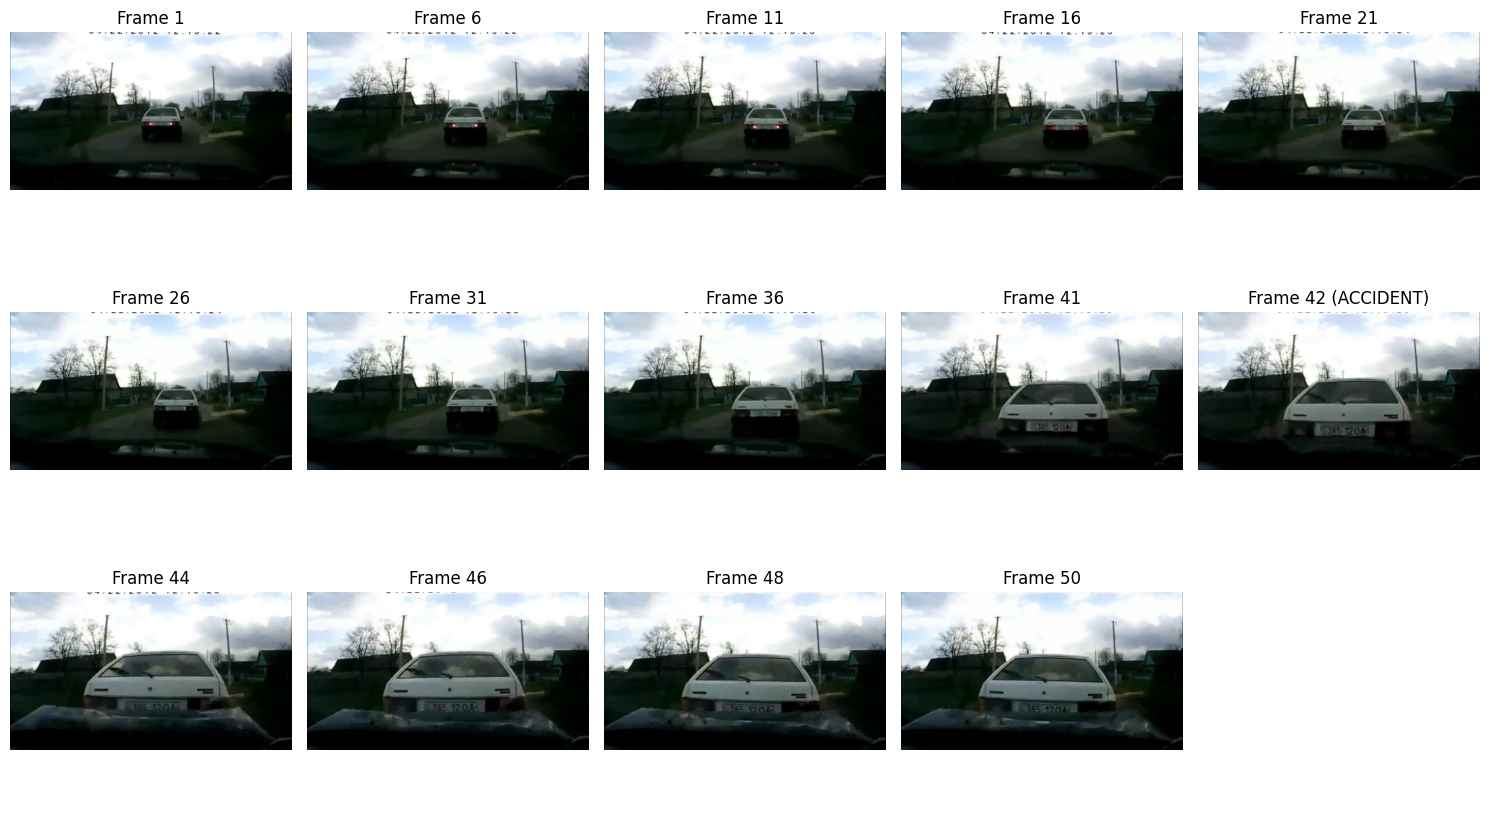


[[ Generated Report ]]

Based on the frames provided, here is a detailed description of the accident:

1. **Initial Situation**: The frames show a white car traveling ahead of the ego vehicle on a narrow road. The road appears to be in a residential area with houses on both sides.

2. **Progression**: The white car is moving at a consistent speed, and the ego vehicle is following closely behind. There are no other vehicles visible in the frames.

3. **Accident Occurrence**: As the frames progress, the distance between the ego vehicle and the white car decreases significantly. The white car appears to slow down or stop, but the ego vehicle does not maintain a safe following distance.

4. **Collision**: In the final frames, the ego vehicle collides with the rear of the white car. The impact is evident as the front of the ego vehicle is visibly closer to the rear of the white car, indicating a rear-end collision.

5. **Fault Analysis**: The ego vehicle is at fault for the accident. It fa

In [17]:
get_report(4, recursive=False, display_img=True)

In [18]:
get_report(4, recursive=True, display_img=False)

Processing batch 01 - frames ['01', '03', '05', '07', '09']...
Processing batch 02 - frames ['11', '13', '15', '17', '19']...
Processing batch 03 - frames ['21', '23', '25', '27', '29']...
Processing batch 04 - frames ['31', '33', '35', '37', '39']...
Processing batch 05 - frames ['41', '43', '45', '47', '49']... Done.

[[ Generated Report ]]

Based on the frames and the earlier description, the accident appears to have occurred due to a rear-end collision. Here's a detailed analysis:

1. **Scene Description**: The setting is a narrow rural road with a white car ahead of the camera-equipped vehicle. The road is lined with houses and leafless trees, indicating a late autumn or early spring setting. The weather is overcast, and there are no visible lane markings.

2. **Progression of Events**:
   - Initially, the white car is traveling steadily in the same direction, maintaining its position in the lane.
   - In the current frames, the distance between the camera-equipped vehicle and the